In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

# **Practical notebook:** Transfer learning and fine-tuning
---

Network to be used: VGG16

![Image in a markdown cell](https://miro.medium.com/max/940/1*3-TqqkRQ4rWLOMX-gvkYwA.png)

# **HOMEWORK 1:** Transfer learning.
---

**Objectives**:  Provide students with practical experience with \\
*	convolutional neural networks \\
*	VGG16, and \\
*	transfer learning

**Description**: The project consists of implementing and assessing the performance of a VGG16 used as “backbone” in three scenarios:
1.	Training from scratch
2.	Using a network pre-trained on ImageNet as a feature extractor
3.	Taking a network pre-trained on ImageNet and fine-tuning the layers

**Experiments**: The students are encouraged to evaluate and compare three approaches as illustrated in the figure and described next:

![](https://drive.google.com/uc?id=1Nh9bftFVrJ99Ncv02DqCoMBBH1h-NUij)

1.	Training from scratch: Use the VGG16 model with no prior training, remove the latest layer (prediction layer) and add a classifier. Train the model from scratch and evaluate.

2.	Using pre-trained network as feature extractor: Use the same model of Exp. 1, but with the VGG16 model pre-trained on ImageNet. Freeze all layers of ResNet50, train and evaluate the model.

3.	Fine-tuning the latest layers: take a pre-trained VGG16 model, unfreeze the last blocks acording to the following: \\
  3-a) - unfreeze the last convolutional blocks (from "block5_conv1"), train and evaluate the model. \\
  3-b) - unfreeze the last convolutional blocks (from "block4_conv1"), train and evaluate the model. \\
  3-c) - unfreeze all convolutional blocks, train and evaluate the model.


**Dataset**: Beans dataset --> Beans is a dataset of images of beans taken in the field using smartphone cameras. It consists of 3 classes: 2 disease classes and the healthy class. The images have dimension 500x500, resize all of them to 224x224. \\
*	Train url ('https://storage.googleapis.com/ibeans/train.zip') \\
*	Validation url: ('https://storage.googleapis.com/ibeans/validation.zip') \\
*	Test url: ('https://storage.googleapis.com/ibeans/test.zip') \\

Select  good  hyper-parameters values  for  your  training  (try  with  different ones). Use the same hyper-parameters configuration for the three experiments.

**Homework Report**: The final report must contain:
1.	A link to the shared notebook containing your code
2.	A pdf file reporting your experiments, includes the results in the form of a table, and discusse the results

Exp ||	train acc	|| train loss	|| val acc || val loss	|| test acc	|| test loss ||
--- || --- || --- || --- || --- || --- || --- ||
1 || --- || --- || --- || --- || --- || --- ||
2 || --- || --- || --- || --- || --- || --- ||
3-a) || --- || --- || --- || --- || --- || --- ||
3-b) || --- || --- || --- || --- || --- || --- ||
3-c) || --- || --- || --- || --- || --- || --- ||

## **Definition of the main functions to be used**

### **Data augmentation**

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(
				height_factor=(-0.05, -0.15),
				width_factor=(-0.05, -0.15)),
])

### **Transfer Learning with VGG16**

In [ ]:
def VGG16(include_top=False, weights='imagenet',input_tensor=None,input_shape=None,pooling=False,classifier_activation=None):
  # Not loaded the last two fully connected layers which act as the classifier.
  # We are just loading the convolutional layers. Note: not specifying the shape of top layers,
  # the input tensor shape is (None, None, 3),so you can use them for any size of images.
  model = tf.keras.applications.vgg16.VGG16(
                                            include_top=include_top,
                                            weights=weights,
                                            input_tensor=input_tensor,
                                            input_shape=input_shape,
                                            pooling=pooling,
                                            classifier_activation=classifier_activation)

  return model


In [ ]:
# Freeze only specific layers of the base model
def freeze_layer(net,freeze_lay_name):

  # Getting layer number through layer name
  for layer_number, layer in enumerate(net.layers):
    if layer.name == freeze_lay_name:
      lay_nb = layer_number
      break

  # Froze layers
  for layer in net.layers[:lay_nb]:
    layer.trainable = False

  return net

In [ ]:
def show_result(acc, val_acc, loss, val_loss):
    plt.rcParams['axes.facecolor']='white'
    f, axarr = plt.subplots(1 , 2)
    f.set_figwidth(10)

    # Accuracy
    axarr[0].plot(acc)
    axarr[0].plot(val_acc)
    axarr[0].set_title('model accuracy')
    axarr[0].set_ylabel('accuracy')
    axarr[0].set_xlabel('epoch')
    axarr[0].legend(['train', 'valid'], loc='upper left')

    # Loss
    axarr[1].plot(loss)
    axarr[1].plot(val_loss)
    axarr[1].set_title('model loss')
    axarr[1].set_ylabel('loss')
    axarr[1].set_xlabel('epoch')
    axarr[1].legend(['train', 'valid'], loc='upper left')

    plt.show()

In [ ]:
def Train(model, epochs, train_dataset, validation_dataset, test_dataset):

    print('Start training')
    # define file name to save the model
    file_name = 'best_model.h5'
    # create checkpoint callbacks to save best model for the validation set
    checkpointer = tf.keras.callbacks.ModelCheckpoint(file_name, monitor='val_accuracy', verbose=10, save_best_only=True)
    # create early stopp callbacks to stop training after not imporvment
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001,
                               mode = 'max', patience = 15)

    # Make first evaluation
    loss0, accuracy0 = model.evaluate(validation_dataset)
    print("initial loss: {:.2f}".format(loss0))
    print("initial accuracy: {:.2f}".format(accuracy0))


    history = model.fit(train_dataset,
                        epochs=epochs,
                        validation_data=validation_dataset,
                        callbacks=[early_stop,checkpointer])


    show_result(history.history['accuracy'],
              history.history['val_accuracy'],
              history.history['loss'],
              history.history['val_loss'])

    del model
    model = tf.keras.models.load_model(file_name)
    loss_val = model.evaluate(validation_dataset)
    loss_test = model.evaluate(test_dataset)

    print("[Validation loss: %f , Validation acc.:%.2f%%]" %(loss_val[0] , 100 * loss_val[1]))
    print("[Test loss: %f , Test acc.:%.2f%%]" %(loss_test[0] , 100 * loss_test[1]))


## **Importing IBeans dataset**

In [ ]:
_URL = 'https://storage.googleapis.com/ibeans/train.zip'
path_to_zip = tf.keras.utils.get_file(os.path.basename(_URL), origin=_URL, extract=True)

_URL_valid = 'https://storage.googleapis.com/ibeans/validation.zip'
path_to_zip_valid = tf.keras.utils.get_file(os.path.basename(_URL_valid), origin=_URL_valid, extract=True)

_URL_test = 'https://storage.googleapis.com/ibeans/test.zip'
path_to_zip_test = tf.keras.utils.get_file(os.path.basename(_URL_test), origin=_URL_test, extract=True)

train_dir = os.path.join(os.path.dirname(path_to_zip), 'train')
validation_dir = os.path.join(os.path.dirname(path_to_zip_valid), 'validation')
test_dir = os.path.join(os.path.dirname(path_to_zip_test), 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode = 'categorical')

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode = 'categorical')

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE,
                                                           label_mode = 'categorical')

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [ ]:
def increase_model(model, activation):
  # Defining a global average pooling layer
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(3, activation=activation)

  # use the preprocessing method included with the model.
  preprocess_input = tf.keras.applications.vgg16.preprocess_input

  # Build a model by chaining together the data augmentation, rescaling,
  # base_model and feature extractor layers using the Keras Functional API.
  inputs = tf.keras.Input(shape=(224, 224, 3))

  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = model(x)
  x = global_average_layer(x)

  # Add classification layer
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  # Compile the model
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

  model.summary()

  return model


## 1) **Training from scratch**
### **Softmax** as activation function

In [ ]:
vgg_scratch = VGG16(weights=None, input_shape=(224,224,3))
vgg_scratch.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_scratch = increase_model(vgg_scratch, 'softmax')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0   

Start training
5/5 [==============================] - 2s 112ms/step - loss: 1.1020 - accuracy: 0.3308
initial loss: 1.10
initial accuracy: 0.33
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.0669 - accuracy: 0.4207
Epoch 1: val_accuracy improved from -inf to 0.33835, saving model to best_model.h5
33/33 [==============================] - 21s 457ms/step - loss: 1.0669 - accuracy: 0.4207 - val_loss: 1.2282 - val_accuracy: 0.3383
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.9379 - accuracy: 0.5571
Epoch 2: val_accuracy improved from 0.33835 to 0.66917, saving model to best_model.h5
33/33 [==============================] - 17s 463ms/step - loss: 0.9379 - accuracy: 0.5571 - val_loss: 0.8028 - val_accuracy: 0.6692
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.8535 - accuracy: 0.6286
Epoch 3: val_accuracy did not improve from 0.66917
33/33 [==============================] - 15s 447ms/step - loss: 0.8535 - accuracy: 0.6286 

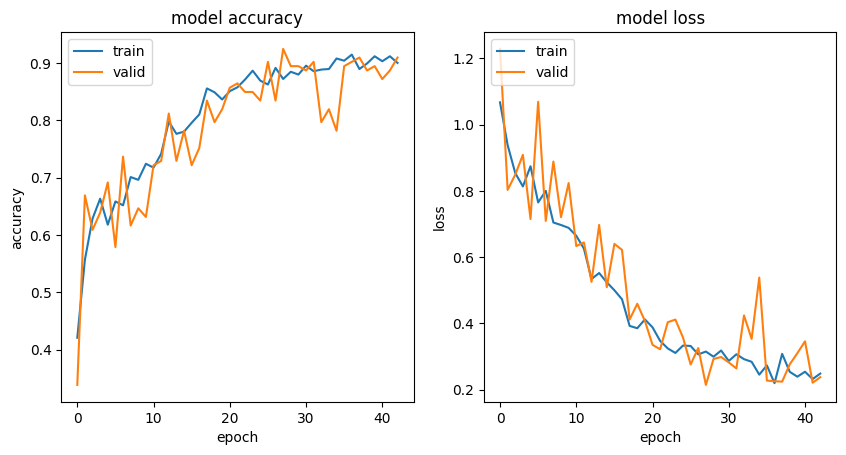

4/4 [==============================] - 1s 131ms/step - loss: 0.3617 - accuracy: 0.8516
[Validation loss: 0.214288 , Validation acc.:92.48%]
[Test loss: 0.361678 , Test acc.:85.16%]


In [ ]:
epochs = 50
Train(vgg_scratch, epochs, train_dataset, validation_dataset, test_dataset)

### **ReLu** as activation function


In [ ]:
vgg_scratch_relu = VGG16(weights=None, input_shape=(224,224,3))
vgg_scratch_relu.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_scratch_relu = increase_model(vgg_scratch_relu, 'relu')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_4   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0   

Start training
5/5 [==============================] - 1s 106ms/step - loss: 1.1364 - accuracy: 0.3308
initial loss: 1.14
initial accuracy: 0.33
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 5.7982 - accuracy: 0.3250
Epoch 1: val_accuracy improved from -inf to 0.33083, saving model to best_model.h5
33/33 [==============================] - 21s 463ms/step - loss: 5.7982 - accuracy: 0.3250 - val_loss: 5.9121 - val_accuracy: 0.3308
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 5.8860 - accuracy: 0.3095
Epoch 2: val_accuracy did not improve from 0.33083
33/33 [==============================] - 16s 449ms/step - loss: 5.8860 - accuracy: 0.3095 - val_loss: 5.9130 - val_accuracy: 0.3308
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 5.8846 - accuracy: 0.3472
Epoch 3: val_accuracy improved from 0.33083 to 0.33835, saving model to best_model.h5
33/33 [==============================] - 16s 461ms/step - loss: 5.8846 - accuracy: 0.3472 

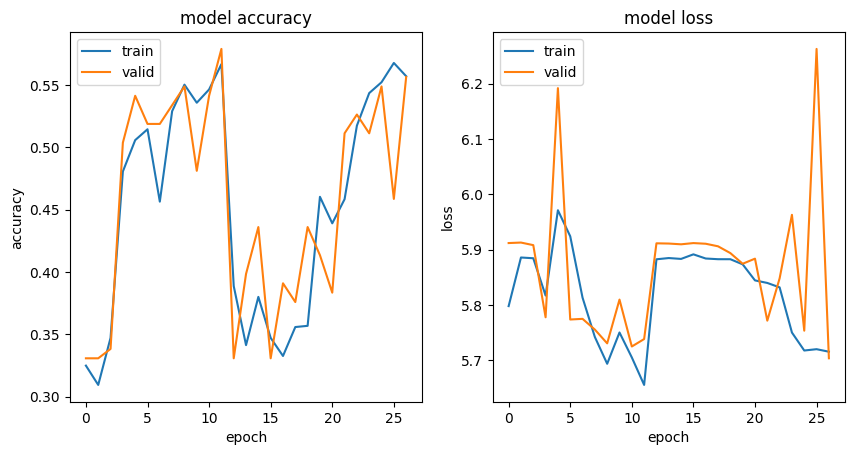

4/4 [==============================] - 1s 133ms/step - loss: 5.5647 - accuracy: 0.5938
[Validation loss: 5.738729 , Validation acc.:57.89%]
[Test loss: 5.564742 , Test acc.:59.38%]


In [ ]:
epochs = 50
Train(vgg_scratch_relu, epochs, train_dataset, validation_dataset, test_dataset)

## **2) Pre-trained Network as Feature Extractor**

In [ ]:
# Freeze up to specific layer of the base model
vgg_imagenet = VGG16(weights='imagenet', input_shape=(224,224,3))
vgg_imagenet = freeze_layer(vgg_imagenet, 'block5_pool')
vgg_imagenet.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_imagenet = increase_model(vgg_imagenet, 'softmax')

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_6   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_6   (None, 512)              0   

Start training
5/5 [==============================] - 1s 109ms/step - loss: 4.0738 - accuracy: 0.3534
initial loss: 4.07
initial accuracy: 0.35
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 3.1430 - accuracy: 0.3288
Epoch 1: val_accuracy improved from -inf to 0.34586, saving model to best_model.h5
33/33 [==============================] - 9s 170ms/step - loss: 3.1430 - accuracy: 0.3288 - val_loss: 3.3677 - val_accuracy: 0.3459
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 2.5814 - accuracy: 0.3327
Epoch 2: val_accuracy did not improve from 0.34586
33/33 [==============================] - 7s 185ms/step - loss: 2.5814 - accuracy: 0.3327 - val_loss: 3.0584 - val_accuracy: 0.3233
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 2.2586 - accuracy: 0.3453
Epoch 3: val_accuracy did not improve from 0.34586
33/33 [==============================] - 6s 169ms/step - loss: 2.2586 - accuracy: 0.3453 - val_loss: 2.7607 - val_accuracy: 0.3

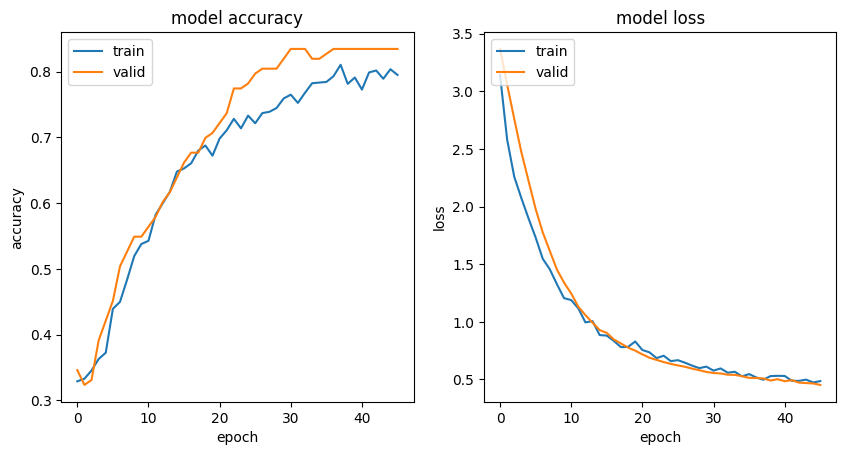

4/4 [==============================] - 1s 136ms/step - loss: 0.7321 - accuracy: 0.7344
[Validation loss: 0.555520 , Validation acc.:83.46%]
[Test loss: 0.732123 , Test acc.:73.44%]


In [ ]:
epochs = 50
Train(vgg_imagenet, epochs, train_dataset, validation_dataset, test_dataset)

## **3) Fine Tuning latest layers**

### **3-a) Unfreeze from "block5_conv1"**

In [ ]:
vgg_imagenet = VGG16(input_shape=(224,224,3), weights='imagenet')
vgg_imagenet = freeze_layer(vgg_imagenet,'block4_pool')
vgg_imagenet.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_imagenet = increase_model(vgg_imagenet, 'softmax')

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_7   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_7 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_7   (None, 512)              0   

Start training
5/5 [==============================] - 1s 110ms/step - loss: 4.1180 - accuracy: 0.2707
initial loss: 4.12
initial accuracy: 0.27
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.2699 - accuracy: 0.5484
Epoch 1: val_accuracy improved from -inf to 0.74436, saving model to best_model.h5
33/33 [==============================] - 11s 193ms/step - loss: 1.2699 - accuracy: 0.5484 - val_loss: 0.6103 - val_accuracy: 0.7444
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.5030 - accuracy: 0.8037
Epoch 2: val_accuracy improved from 0.74436 to 0.85714, saving model to best_model.h5
33/33 [==============================] - 7s 202ms/step - loss: 0.5030 - accuracy: 0.8037 - val_loss: 0.3406 - val_accuracy: 0.8571
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.3353 - accuracy: 0.8733
Epoch 3: val_accuracy improved from 0.85714 to 0.86466, saving model to best_model.h5
33/33 [==============================] - 7s 196ms/step -

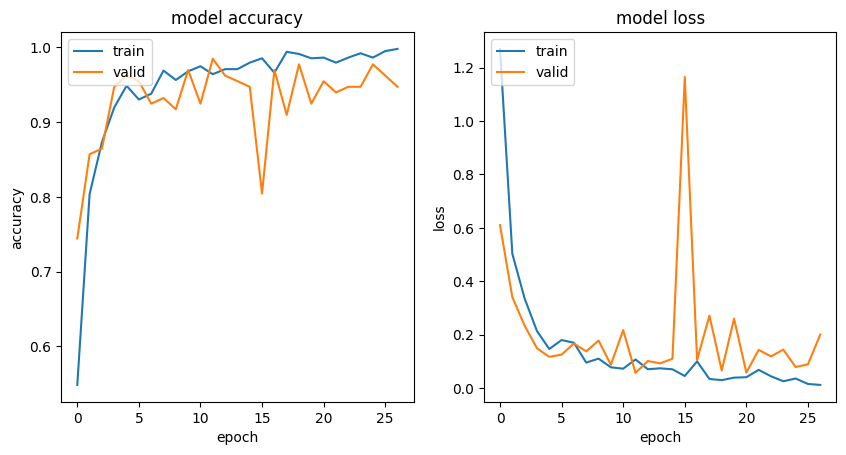

4/4 [==============================] - 1s 135ms/step - loss: 0.1364 - accuracy: 0.9531
[Validation loss: 0.056881 , Validation acc.:98.50%]
[Test loss: 0.136397 , Test acc.:95.31%]


In [ ]:
epochs = 50
Train(vgg_imagenet, epochs, train_dataset, validation_dataset, test_dataset)

### **3-b) Unfreeze from "block4_conv1"**

In [ ]:
# Freeze up to specific layer of the base model
vgg_imagenet = VGG16(input_shape=(224,224,3), weights='imagenet')
vgg_imagenet = freeze_layer(vgg_imagenet,'block3_pool')
vgg_imagenet.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_imagenet = increase_model(vgg_imagenet, 'softmax')

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_8   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_8 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_8   (None, 512)              0   

Start training
5/5 [==============================] - 1s 109ms/step - loss: 12.4957 - accuracy: 0.3308
initial loss: 12.50
initial accuracy: 0.33
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.1568 - accuracy: 0.6035
Epoch 1: val_accuracy improved from -inf to 0.81955, saving model to best_model.h5
33/33 [==============================] - 12s 252ms/step - loss: 1.1568 - accuracy: 0.6035 - val_loss: 0.4699 - val_accuracy: 0.8195
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.8385
Epoch 2: val_accuracy improved from 0.81955 to 0.89474, saving model to best_model.h5
33/33 [==============================] - 10s 256ms/step - loss: 0.4230 - accuracy: 0.8385 - val_loss: 0.2836 - val_accuracy: 0.8947
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7843
Epoch 3: val_accuracy did not improve from 0.89474
33/33 [==============================] - 8s 237ms/step - loss: 0.4954 - accuracy: 0.7843

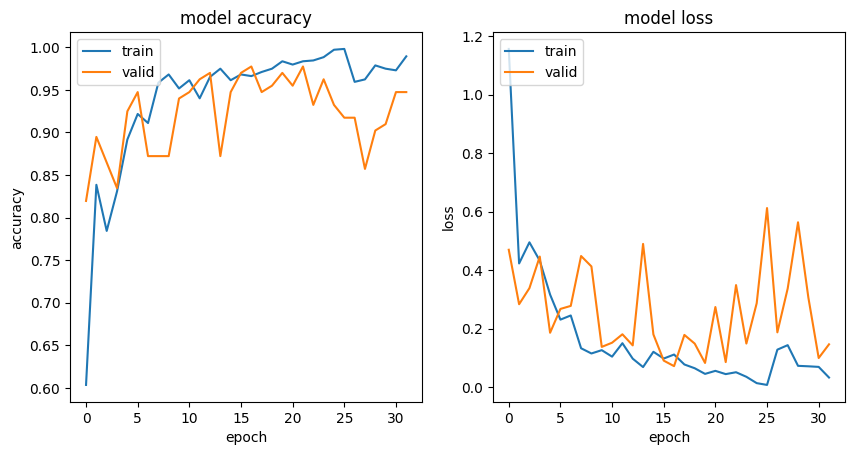

4/4 [==============================] - 1s 134ms/step - loss: 0.1223 - accuracy: 0.9453
[Validation loss: 0.071820 , Validation acc.:97.74%]
[Test loss: 0.122319 , Test acc.:94.53%]


In [ ]:
epochs = 50
Train(vgg_imagenet, epochs, train_dataset, validation_dataset, test_dataset)

### **3-c) Unfreeze all convolutional blocks**

In [ ]:
# Freeze up to specific layer of the base model
vgg_imagenet = VGG16(input_shape=(224,224,3), weights='imagenet')
vgg_imagenet.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
vgg_imagenet = increase_model(vgg_imagenet, 'softmax')

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_9   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_9 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_9   (None, 512)              0   

Start training
5/5 [==============================] - 1s 110ms/step - loss: 4.2310 - accuracy: 0.2932
initial loss: 4.23
initial accuracy: 0.29
Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 1.1937 - accuracy: 0.5048
Epoch 1: val_accuracy improved from -inf to 0.64662, saving model to best_model.h5
33/33 [==============================] - 21s 481ms/step - loss: 1.1937 - accuracy: 0.5048 - val_loss: 0.7837 - val_accuracy: 0.6466
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.7631 - accuracy: 0.6402
Epoch 2: val_accuracy improved from 0.64662 to 0.72932, saving model to best_model.h5
33/33 [==============================] - 16s 474ms/step - loss: 0.7631 - accuracy: 0.6402 - val_loss: 0.7746 - val_accuracy: 0.7293
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.7118
Epoch 3: val_accuracy did not improve from 0.72932
33/33 [==============================] - 16s 453ms/step - loss: 0.6657 - accuracy: 0.7118 

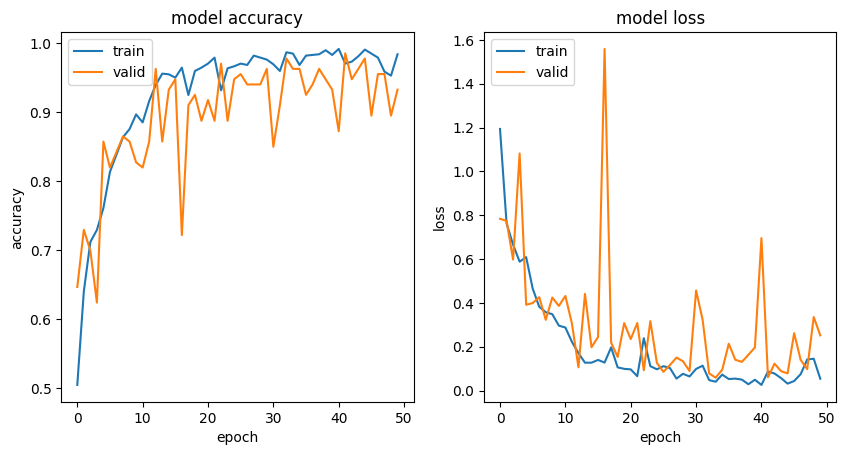

4/4 [==============================] - 1s 135ms/step - loss: 0.1456 - accuracy: 0.9453
[Validation loss: 0.060594 , Validation acc.:98.50%]
[Test loss: 0.145559 , Test acc.:94.53%]


In [ ]:
epochs = 50
Train(vgg_imagenet, epochs, train_dataset, validation_dataset, test_dataset)